In [2]:
import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

In [3]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
models_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
sys.path.append(api_path)

In [4]:
import numpy as np
import sklearn.datasets
import time
import random

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (Evolution,
                   prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from gan_train import train_gan
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           visualize_fake_data_projection,
                           discriminator_2d_visualization,
                           mh_sampling_visualize,
                           epoch_visualization)
from mh_2d_sampling import mh_sampling
from ebm_sampling import (calculate_energy,
                          Langevin_sampling, 
                          MALA_sampling,
                          NUTS_sampling)

/usr/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
from sklearn.preprocessing import StandardScaler
random_seed = 42
train_dataset_size = 64000
sigma = 0.05

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [6]:
n_dim = 2
n_layers_g = 4
n_hid_g = 100
n_out = 2

n_layers_d = 4
n_hid_d = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [7]:
import glob
discriminator_regexp = os.path.join(models_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

In [8]:
G.load_state_dict(torch.load(generator_name))
D.load_state_dict(torch.load(discriminator_name))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
epoch = 1000
path_to_save = None
batch_size_sample = 5000  

In [ ]:
G = G.to(device)
D = D.to(device)

In [ ]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [ ]:
sample_fake_data(G, X_train, epoch, path_to_save, 
                 scaler = scaler,
                 batch_size_sample = batch_size_sample)

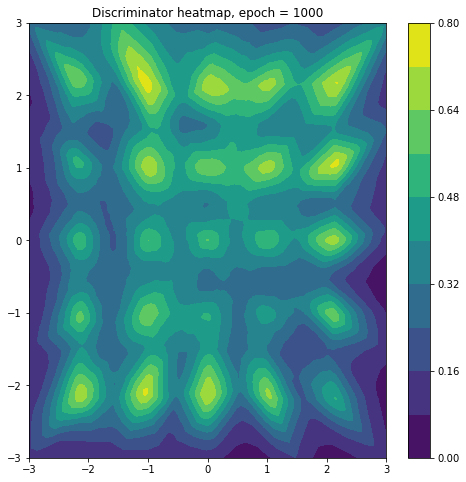

In [19]:
x_range = 3.0
y_range = 3.0
discriminator_2d_visualization(D,
                               x_range,
                               y_range,
                               path_to_save,
                               epoch,
                               scaler = scaler,
                               num_points = 700)

  0%|          | 0/5000 [00:00<?, ?it/s]

Start to do MH sampling....


100%|██████████| 5000/5000 [01:09<00:00, 72.38it/s]


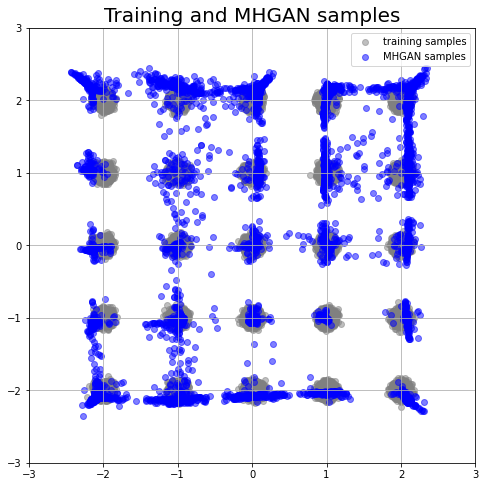

In [20]:
n_calib_pts = 10000
type_calibrator = 'iso'
normalize_to_0_1 = True
mh_sampling_visualize(G, 
                      D,
                      X_train, epoch, 
                      path_to_save,
                      n_calib_pts = n_calib_pts,
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      type_calibrator = type_calibrator,
                      normalize_to_0_1 = normalize_to_0_1)

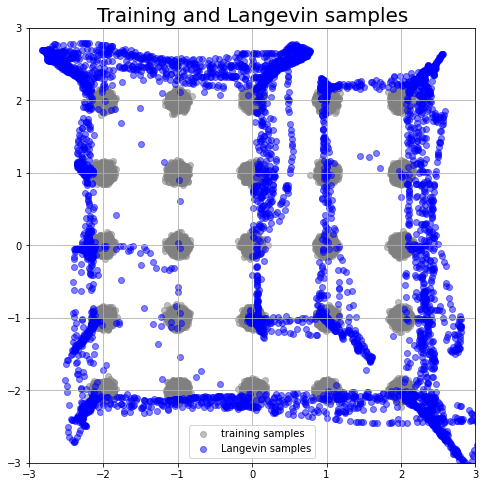

In [25]:
z_dim = G.n_dim
eps = 1e-3
num_iter = batch_size_sample
langevin_samples = Langevin_sampling(G, D, z_dim, eps, num_iter, device)
fake_langevin = G(langevin_samples).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(fake_langevin, X_train, mode, path_to_save, 
                    scaler = scaler)

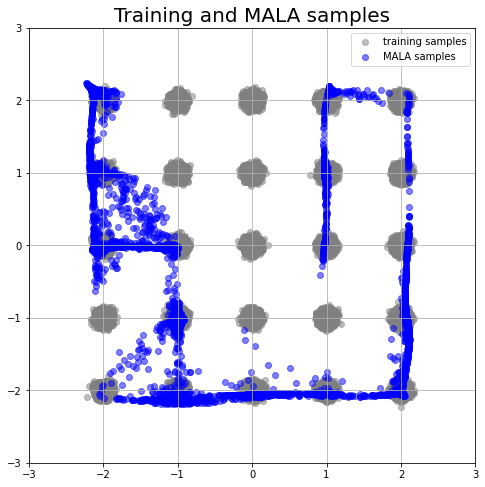

In [28]:
z_dim = G.n_dim
eps = 1e-3
num_iter = batch_size_sample
mala_samples = MALA_sampling(G, D, z_dim, eps, num_iter, device)
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

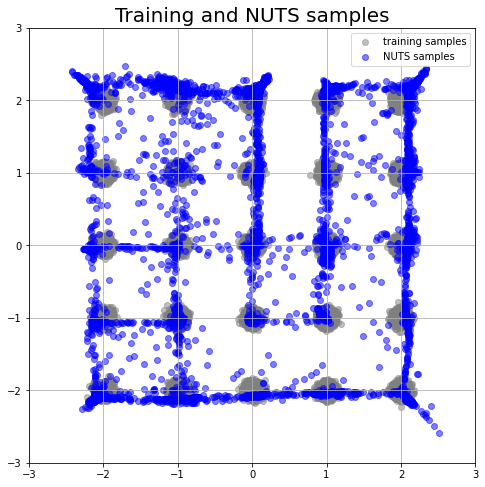

In [31]:
fake_nuts = G(nuts_samples[0]).data.cpu().numpy()
mode = 'NUTS'
plot_fake_data_mode(fake_nuts, X_train, mode, path_to_save, 
                    scaler = scaler)

In [23]:
def visualize_potential_energy(discriminator,
                               generator,
                               x_range,
                               y_range,
                               normalize_to_0_1 = True,
                               num_points = 700):
    x = torch.linspace(-x_range, x_range, num_points)
    y = torch.linspace(-y_range, y_range, num_points)
    x_t = x.view(-1, 1).repeat(1, y.size(0))
    y_t = y.view(1, -1).repeat(x.size(0), 1)
    x_t_batch = x_t.view(-1 , 1)
    y_t_batch = y_t.view(-1 , 1)
    batch = torch.zeros((x_t_batch.shape[0], 2))
    batch[:, 0] = x_t_batch[:, 0]
    batch[:, 1] = y_t_batch[:, 0]
    batch = batch.to(discriminator.device)
    generator_batch = generator(batch)
    
    dist_batch = (torch.norm(batch, p=2, dim=-1) ** 2)/2.0
    dist_batch = dist_batch.to(discriminator.device)

    if normalize_to_0_1:
        discr_batch = -discriminator(generator_batch).view(-1)
    else:
        discr_batch = -discriminator(generator_batch).sigmoid().view(-1)
    
    result = discr_batch + dist_batch
    heatmap = result.view((num_points, 
                           num_points)).detach().cpu().numpy()
    x_numpy = x.numpy()
    y_numpy = y.numpy()
    y, x = np.meshgrid(x_numpy, y_numpy)
    l_x=x_numpy.min()
    r_x=x_numpy.max()
    l_y=y_numpy.min()
    r_y=y_numpy.max()
    #small_heatmap = sigmoid_heatmap[:-1, :-1]
    figure, axes = plt.subplots(figsize=(8, 8))
    z = axes.contourf(x, y, heatmap, 10, cmap='viridis')
    title = f"Latent energy"
    axes.set_title(title)
    axes.axis([l_x, r_x, l_y, r_y])
    figure.colorbar(z)

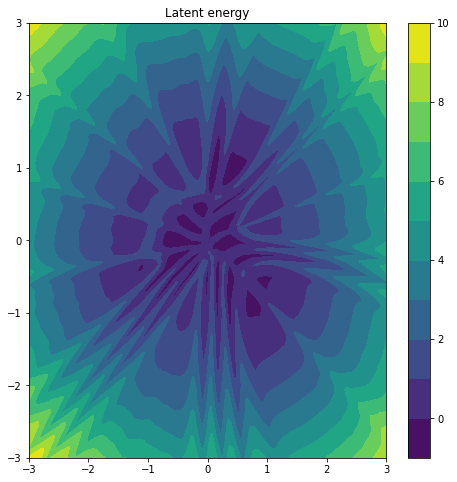

In [24]:
x_range = 3.0
y_range = 3.0
visualize_potential_energy(D,
                           G,
                           x_range,
                           y_range)

In [101]:
def calculate_energy(params, generator, discriminator):
    generator_points = generator(params)
    GAN_part = -discriminator(generator_points).view(-1)
    prior_part = (torch.norm(params, p=2, dim=-1) ** 2)/2
    return (GAN_part + prior_part).sum()


def visualize_norm_grads_potential_energy(discriminator,
                                          generator,
                                          x_range,
                                          y_range,
                                          num_points = 100):
    x = torch.linspace(-x_range, x_range, num_points)
    y = torch.linspace(-y_range, y_range, num_points)
    x_t = x.view(-1, 1).repeat(1, y.size(0))
    y_t = y.view(1, -1).repeat(x.size(0), 1)
    x_t_batch = x_t.view(-1 , 1)
    y_t_batch = y_t.view(-1 , 1)
    batch = torch.zeros((x_t_batch.shape[0], 2))
    batch[:, 0] = x_t_batch[:, 0]
    batch[:, 1] = y_t_batch[:, 0]

    batch = batch.to(discriminator.device)
    energy_fun = partial(calculate_energy, 
                         generator = generator,
                         discriminator = discriminator)
    batch.requires_grad_(True)
    batch_energy = energy_fun(batch).sum()
    batch_energy.backward()
    batch_grads = batch.grad.detach().cpu()
    batch_grads_norm = torch.norm(batch_grads, p=2, dim=-1)
    batch_grads_norm = batch_grads_norm.view((num_points, 
                                              num_points)).detach().cpu().numpy()
    
    x_numpy = x.numpy()
    y_numpy = y.numpy()
    y, x = np.meshgrid(x_numpy, y_numpy)
    l_x=x_numpy.min()
    r_x=x_numpy.max()
    l_y=y_numpy.min()
    r_y=y_numpy.max()
    #small_heatmap = sigmoid_heatmap[:-1, :-1]
    figure, axes = plt.subplots(figsize=(8, 8))
    z = axes.contourf(x, y, batch_grads_norm, 10, cmap='viridis')
    title = f"Latent energy norm gradients"
    axes.set_title(title)
    axes.axis([l_x, r_x, l_y, r_y])
    figure.colorbar(z)
    return batch_grads

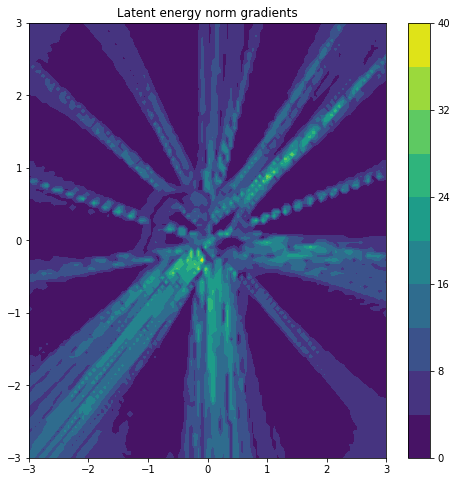

In [102]:
x_range = 3.0
y_range = 3.0
batch_grads = visualize_norm_grads_potential_energy(D,
                                      G,
                                      x_range,
                                      y_range)

In [105]:
energy_fun = partial(calculate_energy, 
                     generator = G,
                     discriminator = D)
point = torch.Tensor([[1.0, -0.5], [1.0, -0.2]]).to(D.device)
point.requires_grad_(True)
batch_energy = energy_fun(point)
batch_energy.backward()
print(point.grad)

tensor([[ 0.1490,  2.5423],
        [ 1.3375, 19.5395]], device='cuda:0')


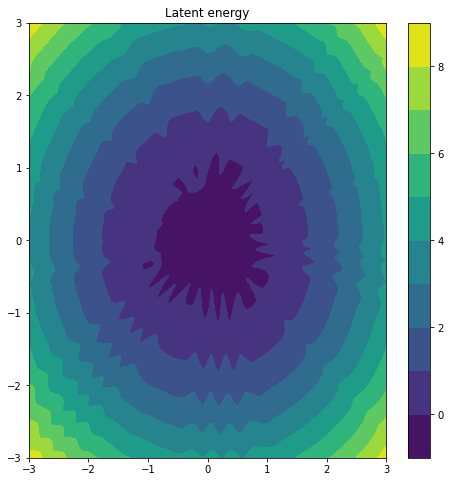

In [56]:
x_range = 3.0
y_range = 3.0
visualize_potential_energy(D,
                           G,
                           x_range,
                           y_range,
                           normalize_to_0_1 = False)

Sample: 100%|██████████| 10000/10000 [08:50, 18.84it/s, step size=5.35e-02, acc. prob=0.830]


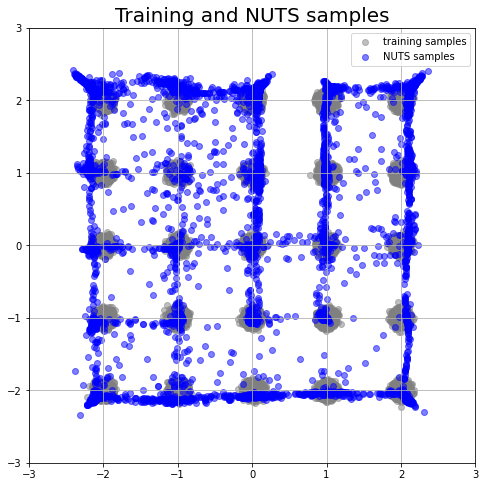

In [11]:
z_dim = G.n_dim
num_iter = batch_size_sample
latent_arr, mcmc = NUTS_sampling(G, D, z_dim, batch_size_sample, device)
fake_nuts = G(latent_arr).data.cpu().numpy()
mode = 'NUTS'
plot_fake_data_mode(fake_nuts, X_train, mode, path_to_save, 
                    scaler = scaler)

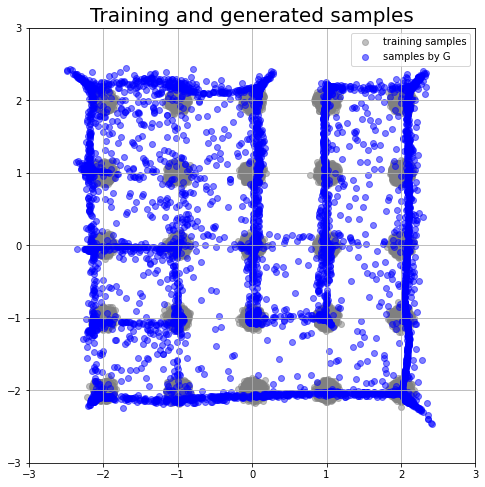

In [12]:
sample_fake_data(G, X_train, epoch, path_to_save, 
                 scaler = scaler,
                 batch_size_sample = batch_size_sample)

In [20]:
def calculate_energy(params, generator, discriminator):
   if params is not None:
      GAN_part = -discriminator(generator(params)).view(-1)
      prior_part = (torch.norm(params, p=2, dim=-1) ** 2)/2
      result = (GAN_part + prior_part).sum()
      return result
   else:
      return torch.tensor([0.0])

In [30]:
z_dim = 2
energy_fun = partial(calculate_energy, 
                     generator = G,
                     discriminator = D)
num_iter = 5000
eps = 1e-3

In [31]:
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)
normal = Normal(loc, scale)
diagn = Independent(normal, 1)
uniform_sampler = Uniform(low = 0.0, high = 1.0)
cur_z = torch.tensor([0.0, 0.0], device = device)
cur_z.requires_grad_(True)
latent_arr = [cur_z.clone()]
#print(f"Start latent point = {cur_z.detach().cpu()}, image = {G(cur_z).detach().cpu()}")
for i in range(num_iter):
    cur_energy = energy_fun(cur_z)
    cur_energy.backward()
    noise = diagn.sample()
    gamma = eps/2
    with torch.no_grad():
        new_z = (cur_z - gamma*cur_z.grad + (eps ** 0.5)*noise)
    new_z = new_z.clone()
    new_z.requires_grad_(True)
    new_energy = energy_fun(new_z)
    new_energy.backward()
    energy_part = cur_energy - new_energy
    with torch.no_grad():
        vec_for_propose_2 = cur_z - new_z + gamma*new_z.grad
    propose_part_2 = (vec_for_propose_2 @ vec_for_propose_2)/4.0/gamma
    propose_part = (noise @ noise)/2.0 - propose_part_2
    log_accept_prob = propose_part + energy_part
    generate_uniform_var = uniform_sampler.sample().to(device)
    log_generate_uniform_var = torch.log(generate_uniform_var)
    if log_generate_uniform_var < log_accept_prob:
        latent_arr.append(new_z.clone())
        cur_z = new_z
        cur_z.grad.data.zero_()
        #print(f"New latent point = {cur_z.detach().cpu()}, image = {G(cur_z).detach().cpu()}")

latent_arr = torch.stack(latent_arr, dim = 0)

In [33]:
latent_arr.shape

torch.Size([4918, 2])

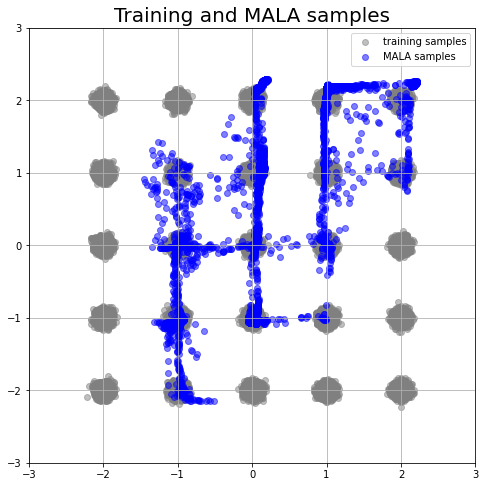

In [32]:
fake_mala = G(latent_arr).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

# Langevin sampling by EBM GAN

In [31]:
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform
from torch.autograd import Variable

def e_grad(z, P, gen, dis, alpha, ret_e=False):
    logp_z = torch.sum(P.log_prob(z), dim=1)
    x = gen(z)
    d = dis(x).view(-1)
    E = (-logp_z - alpha * d).sum()
    # E = - alpha * d
    E.backward()
    grad = z.grad
    # prior_grad = chainer.grad((-logp_z, ), (z, ))
    # d_grad = chainer.grad((d, ), (z, ))
    # import pdb
    # pdb.set_trace()
    if ret_e:
        return E, grad
    return grad

In [23]:
def calculate_energy(params, generator, discriminator):
    generator_points = generator(params)
    GAN_part = -discriminator(generator_points).view(-1)
    prior_part = (torch.norm(params, p=2, dim=-1) ** 2)/2
    return (GAN_part + prior_part).sum()

In [24]:
energy_fun = partial(calculate_energy, 
                     generator = G,
                     discriminator = D)
point = torch.Tensor([[1.0, -0.5], [1.0, -0.2]]).to(D.device)
point.requires_grad_(True)
batch_energy = energy_fun(point)
batch_energy.backward()
print(point.grad)

tensor([[ 0.1490,  2.5423],
        [ 1.3375, 19.5395]], device='cuda:0')


In [25]:
z_dim = 2
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)
P = Normal(loc, scale)
alpha = 1.0
z = torch.Tensor([[1.0, -0.5], [1.0, -0.2]]).to(D.device)
z.requires_grad_(True)
grads = e_grad(z, P, G, D, alpha, ret_e=False)
print(grads)

tensor([[ 0.1490,  2.5423],
        [ 1.3375, 19.5395]], device='cuda:0')


In [27]:
z_dim = 2
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)
P = Normal(loc, scale)
alpha = 1.0
z = torch.Tensor([[1.0, -0.5]]).to(D.device)
z.requires_grad_(True)
grads = e_grad(z, P, G, D, alpha, ret_e=False)
print(grads)

tensor([[0.1490, 2.5423]], device='cuda:0')


In [117]:
def langevin_dynamics(z, gen, dis, alpha, n_steps, step_lr, eps_std):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]
    loc = torch.zeros(z_dim).to(gen.device)
    scale = torch.ones(z_dim).to(gen.device)
    normal = Normal(loc, scale)

    for _ in range(n_steps):
        z_sp.append(z)
        eps = eps_std * normal.sample([batch_size])

        E, grad = e_grad(z, normal, gen, dis, alpha, ret_e=True)
        z = z - step_lr * grad + eps        

        #z = torch.clamp(z.data, -1., 1.)
        z.requires_grad_(True)
    z_sp.append(z)
    # print(n_steps, len(z_sp), z.shape)
    return z_sp

In [134]:
alpha = 1.0
n_steps = 100
step_lr = 1e-3
eps_std = 1e-3

In [113]:
z = P.sample([100])
z.requires_grad_(True)
latent_arr = langevin_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)

In [115]:
latent_arr[-1].shape

torch.Size([100, 2])

In [135]:
from tqdm import tqdm 
def langevin_sample(gen, dis, alpha, n_steps, step_lr, eps_std, n=5000, batchsize=100):
    ims = []
    zs = []
    for i in tqdm(range(0, n, batchsize)):
        z = gen.make_hidden(batchsize)
        z.requires_grad_(True)
        z_sp = langevin_dynamics(z, gen, dis, alpha, n_steps, step_lr, eps_std)
        x = gen(z_sp[-1]).data.cpu().numpy()
        ims.append(x)
        zs.append(np.stack([o.data.cpu().numpy() for o in z_sp], axis=0))

    ims = np.asarray(ims)
    zs = np.stack(zs, axis=0)
    return ims, zs

In [136]:
ims, zs = langevin_sample(G, D, alpha, n_steps, step_lr, eps_std, n=5000, batchsize=100)

100%|██████████| 50/50 [00:06<00:00,  7.56it/s]


In [137]:
ims = ims.reshape((-1, 2))

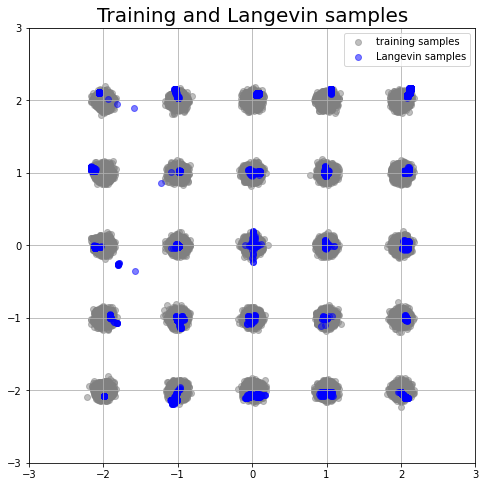

In [138]:
mode = 'Langevin'
plot_fake_data_mode(ims, X_train, mode, path_to_save, 
                    scaler = scaler)

In [140]:
ims, zs = langevin_sample(G, D, alpha, n_steps, step_lr, eps_std, n=50000, batchsize=100)

100%|██████████| 500/500 [01:10<00:00,  7.13it/s]


In [141]:
ims = ims.reshape((-1, 2))

In [143]:
ims.shape

(50000, 2)

In [144]:
alpha = 1.0
n_steps = 100
step_lr = 1e-3
eps_std = 1e-2

In [147]:
ims, zs = langevin_sample(G, D, alpha, n_steps, step_lr, eps_std, n=5000, batchsize=100)
ims = ims.reshape((-1, 2))

100%|██████████| 50/50 [00:06<00:00,  7.64it/s]


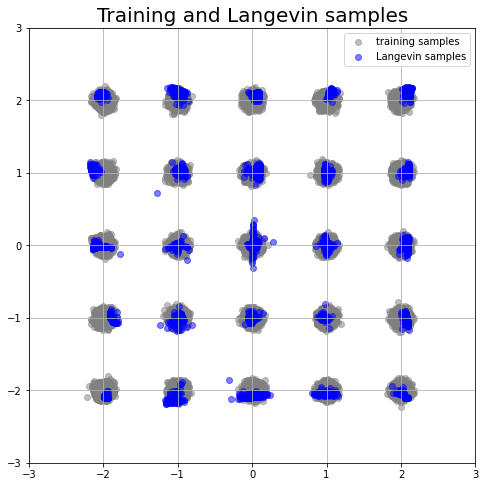

In [148]:
mode = 'Langevin'
plot_fake_data_mode(ims, X_train, mode, path_to_save, 
                    scaler = scaler)

In [170]:
alpha = 1.0
n_steps = 100
step_lr = 1e-1
eps_std = 1e-2

In [171]:
ims, zs = langevin_sample(G, D, alpha, n_steps, step_lr, eps_std, n=5000, batchsize=100)
ims = ims.reshape((-1, 2))

100%|██████████| 50/50 [00:06<00:00,  7.84it/s]


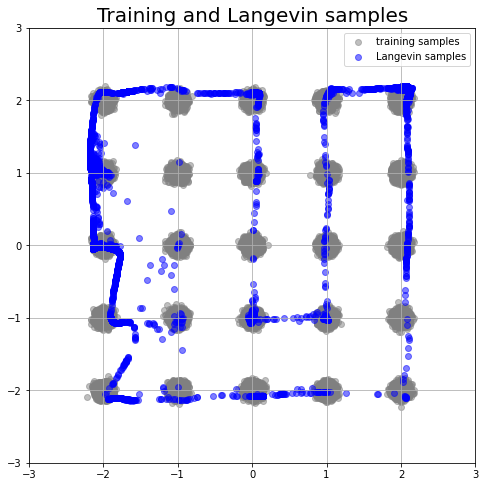

In [172]:
mode = 'Langevin'
plot_fake_data_mode(ims, X_train, mode, path_to_save, 
                    scaler = scaler)

In [167]:
alpha = 1.0
n_steps = 100
step_lr = 1e-4
eps_std = 1e-2

In [168]:
ims, zs = langevin_sample(G, D, alpha, n_steps, step_lr, eps_std, n=5000, batchsize=100)
ims = ims.reshape((-1, 2))

100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


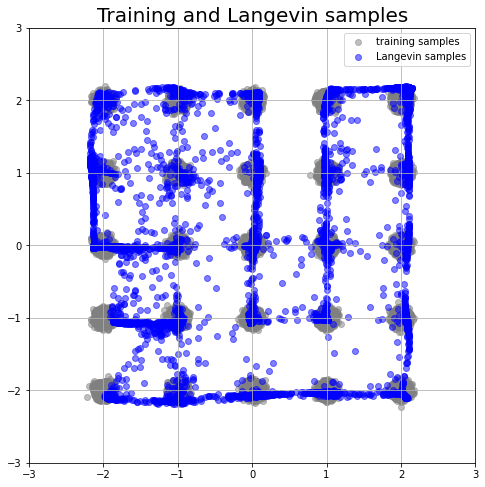

In [169]:
mode = 'Langevin'
plot_fake_data_mode(ims, X_train, mode, path_to_save, 
                    scaler = scaler)

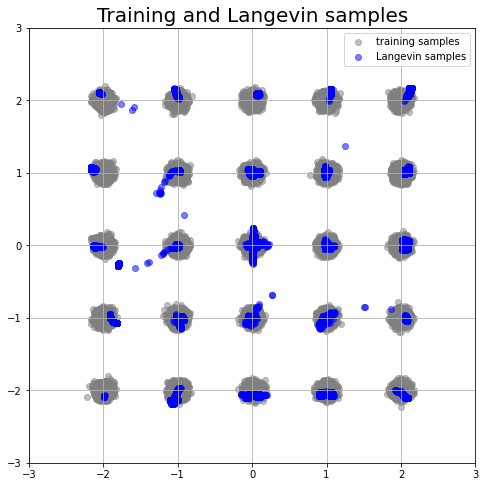

In [142]:
mode = 'Langevin'
plot_fake_data_mode(ims, X_train, mode, path_to_save, 
                    scaler = scaler)

In [81]:
alpha = 1.0
n_steps = 10000
step_lr = 1e-4
eps_std = 1e-3

In [82]:
z = P.sample([1])
z.requires_grad_(True)
latent_arr = langevin_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)

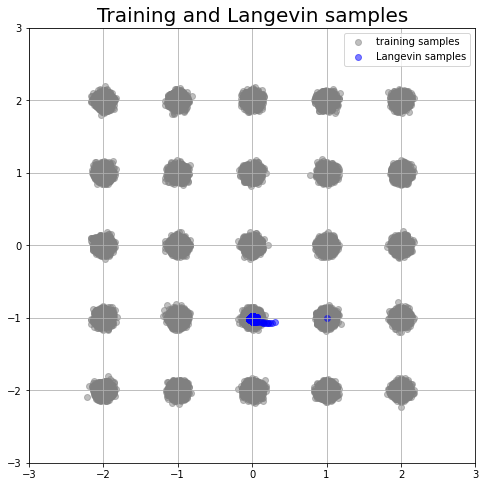

In [83]:
latent_arr = torch.stack(latent_arr, dim = 0).squeeze()
res = G(latent_arr).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(res, X_train, mode, path_to_save, 
                    scaler = scaler)

In [87]:
alpha = 1.0
n_steps = 10000
step_lr = 1e-3
eps_std = 1e-3

In [88]:
z = P.sample([1])
z.requires_grad_(True)
latent_arr = langevin_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)

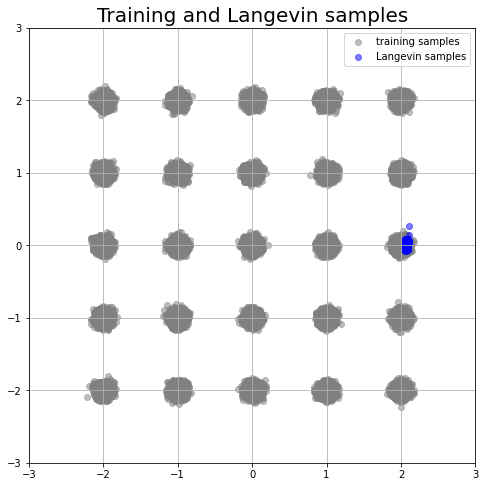

In [89]:
latent_arr = torch.stack(latent_arr, dim = 0).squeeze()
res = G(latent_arr).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(res, X_train, mode, path_to_save, 
                    scaler = scaler)

In [90]:
alpha = 1.0
n_steps = 10000
step_lr = 1e-3
eps_std = 1e-2

In [91]:
z = P.sample([1])
z.requires_grad_(True)
latent_arr = langevin_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)

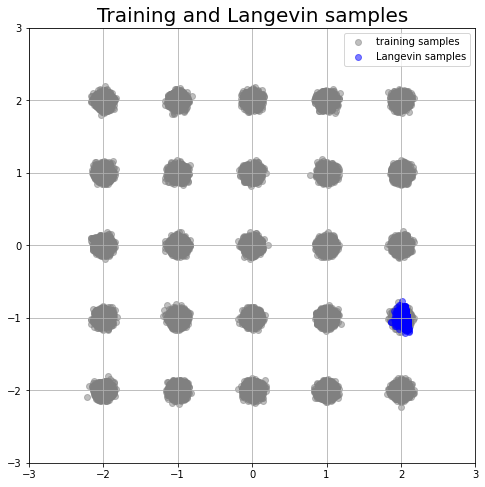

In [92]:
latent_arr = torch.stack(latent_arr, dim = 0).squeeze()
res = G(latent_arr).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(res, X_train, mode, path_to_save, 
                    scaler = scaler)

In [93]:
alpha = 1.0
n_steps = 10000
step_lr = 1e-3
eps_std = 1e-1

In [94]:
z = P.sample([1])
z.requires_grad_(True)
latent_arr = langevin_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)

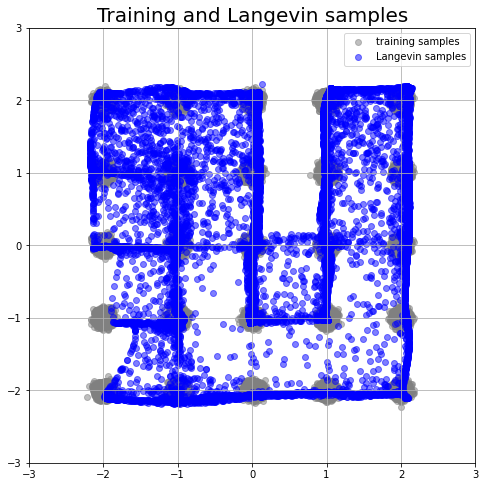

In [95]:
latent_arr = torch.stack(latent_arr, dim = 0).squeeze()
res = G(latent_arr).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(res, X_train, mode, path_to_save, 
                    scaler = scaler)

In [96]:
alpha = 1.0
n_steps = 10000
step_lr = 1e-2
eps_std = 1e-2

In [97]:
z = P.sample([1])
z.requires_grad_(True)
latent_arr = langevin_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)

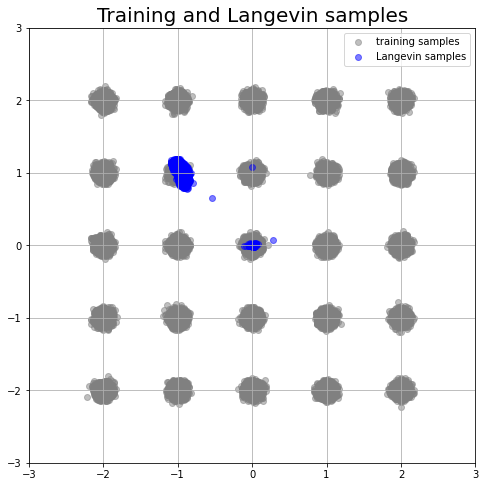

In [98]:
latent_arr = torch.stack(latent_arr, dim = 0).squeeze()
res = G(latent_arr).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(res, X_train, mode, path_to_save, 
                    scaler = scaler)

In [99]:
alpha = 1.0
n_steps = 10000
step_lr = 1e-1
eps_std = 1e-2

In [100]:
z = P.sample([1])
z.requires_grad_(True)
latent_arr = langevin_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)

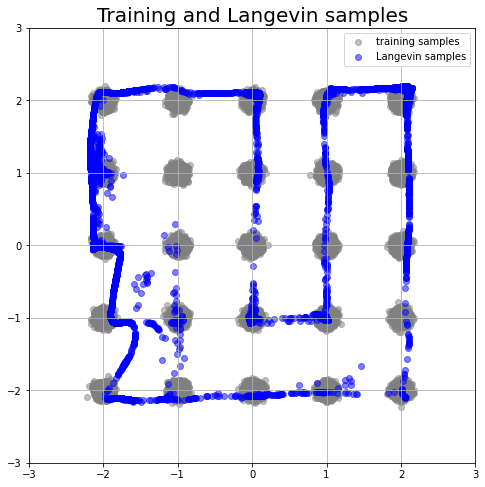

In [101]:
latent_arr = torch.stack(latent_arr, dim = 0).squeeze()
res = G(latent_arr).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(res, X_train, mode, path_to_save, 
                    scaler = scaler)

In [102]:
alpha = 1.0
n_steps = 10000
step_lr = 1e-1
eps_std = 1e-3

In [103]:
z = P.sample([1])
z.requires_grad_(True)
latent_arr = langevin_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)

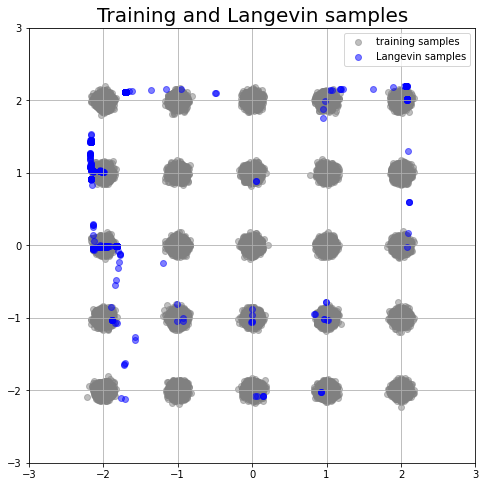

In [104]:
latent_arr = torch.stack(latent_arr, dim = 0).squeeze()
res = G(latent_arr).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(res, X_train, mode, path_to_save, 
                    scaler = scaler)

In [106]:
alpha = 1.0
n_steps = 10000
step_lr = 1e-2
eps_std = 1e-3

In [107]:
z = P.sample([1])
z.requires_grad_(True)
latent_arr = langevin_dynamics(z, G, D, alpha, n_steps, step_lr, eps_std)

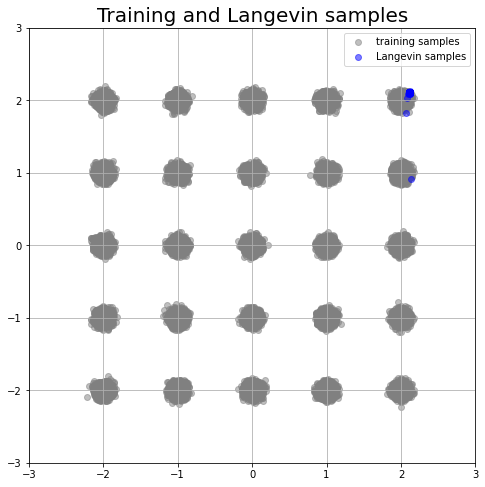

In [108]:
latent_arr = torch.stack(latent_arr, dim = 0).squeeze()
res = G(latent_arr).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(res, X_train, mode, path_to_save, 
                    scaler = scaler)

In [ ]:
def langevin_sample(gen, dis, config, n=50000, batchsize=100):
    ims = []
    zs = []
    xp = gen.xp
    alpha = config.langevin['alpha']
    n_steps = config.langevin['n_steps']
    step_lr = config.langevin['step_lr']
    eps_std = config.langevin['eps_std']
    for i in range(0, n, batchsize):
        with chainer.using_config('train', False):
            z = Variable(gen.sample_z(batchsize))
            z_sp = langevin_dynamics(z, gen, dis, alpha, n_steps, step_lr, eps_std)
        x = gen(batchsize, z_sp[-1])
        x = chainer.cuda.to_cpu(x.data)
        ims.append(x)
        zs.append(np.stack([chainer.cuda.to_cpu(o.data) for o in z_sp], axis=0))
        # if i % 50 == 0:
            # print(i)
    ims = np.asarray(ims)
    zs = np.stack(zs, axis=0)
    return ims, zs